In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader


In [39]:

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the true function (non-separable)
def true_function(k1, k2, k3, testmod=2):
    if testmod==1:
        return k1**2 / (k2 * k3) + k2**2 / (k1 * k3) + k3**2 / (k1 * k2)
    elif testmod==2:
        return 1/(k1+k2+k3)
    else:
        raise NotImplementedError

# Create a grid-based dataset
def create_grid_dataset(grid_points, min_val=0.1, max_val=2.0):
    k_values = np.linspace(min_val, max_val, grid_points)
    k1, k2, k3 = np.meshgrid(k_values, k_values, k_values)
    X = np.stack([k1.flatten(), k2.flatten(), k3.flatten()], axis=1)
    y = true_function(X[:, 0], X[:, 1], X[:, 2])
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Define a more complex sub-network
class SubNetwork(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.net(x)

# Define the improved model
class ImprovedSeparableApproximation(nn.Module):
    def __init__(self, num_terms=10):
        super().__init__()
        self.num_terms = num_terms
        self.f1 = nn.ModuleList([SubNetwork(1) for _ in range(num_terms)])
        self.f2 = nn.ModuleList([SubNetwork(1) for _ in range(num_terms)])
        self.f3 = nn.ModuleList([SubNetwork(1) for _ in range(num_terms)])
        self.weights = nn.Parameter(torch.ones(num_terms))

    def forward(self, x):
        k1, k2, k3 = x[:, 0].view(-1, 1), x[:, 1].view(-1, 1), x[:, 2].view(-1, 1)
        # adding permutations to impose symmetry
        result = sum( self.weights[i] * self.f1[i](k1) * self.f2[i](k2) * self.f3[i](k3)\
                     +self.weights[i] * self.f1[i](k2) * self.f2[i](k1) * self.f3[i](k3)\
                     +self.weights[i] * self.f1[i](k3) * self.f2[i](k2) * self.f3[i](k1) for i in range(self.num_terms))
        return result

# Train the model
def train_model(model, train_loader, val_loader, epochs=300):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5, verbose=True)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        epoch_loss /= len(train_loader)
        train_losses.append(epoch_loss)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                val_outputs = model(batch_X)
                val_loss += criterion(val_outputs, batch_y).item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        scheduler.step(val_loss)
        
        if epoch % 1 == 0:
            print(f"Epoch {epoch}, Train Loss: {epoch_loss:.6f}, Val Loss: {val_loss:.6f}")
    
    return train_losses, val_losses

# Evaluate the model
def evaluate_model(model, test_loader, train_losses, val_losses):
    model.eval()
    total_mse = 0
    all_y = []
    all_y_pred = []
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            y_pred = model(batch_X)
            total_mse += nn.MSELoss()(y_pred, batch_y).item() * batch_y.size(0)
            all_y.extend(batch_y.cpu().numpy())
            all_y_pred.extend(y_pred.cpu().numpy())
    
    avg_mse = total_mse / len(test_loader.dataset)
    print(f"Mean Squared Error: {avg_mse:.6f}")

    all_y = np.array(all_y)
    all_y_pred = np.array(all_y_pred)
    
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.scatter(all_y, all_y_pred, alpha=0.1)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('True vs Predicted')

    plt.subplot(132)
    plt.scatter(all_y, all_y_pred / all_y-1, alpha=0.1)
    plt.xlabel('True Values')
    plt.ylabel('Fractional difference)')
    plt.ylim(-0.1, 0.1)
    plt.title('Residuals')

    plt.subplot(133)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


Using device: cpu


In [36]:
# Main execution
batch_size = 128  # Define batch size here

X_train, y_train = create_grid_dataset(grid_points=100)  # 10^3 = 1000 total points for training
X_val, y_val = create_grid_dataset(grid_points=10)  # 5^3 = 125 total points for validation
X_test, y_test = create_grid_dataset(grid_points=20)  # 5^3 = 125 total points for validation

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

test_loader = DataLoader(test_dataset, batch_size=batch_size)



In [44]:
model = ImprovedSeparableApproximation(num_terms=2).to(device)
train_losses, val_losses = train_model(model, train_loader, val_loader, epochs=10)


Epoch 0, Train Loss: 0.000453, Val Loss: 0.000305
Epoch 1, Train Loss: 0.000036, Val Loss: 0.000184
Epoch 2, Train Loss: 0.000030, Val Loss: 0.000182
Epoch 3, Train Loss: 0.000027, Val Loss: 0.000190
Epoch 4, Train Loss: 0.000027, Val Loss: 0.000201
Epoch 5, Train Loss: 0.000026, Val Loss: 0.000256
Epoch 6, Train Loss: 0.000024, Val Loss: 0.000205
Epoch 7, Train Loss: 0.000024, Val Loss: 0.000188
Epoch 8, Train Loss: 0.000023, Val Loss: 0.000211
Epoch 9, Train Loss: 0.000024, Val Loss: 0.000239


Mean Squared Error: 0.000055


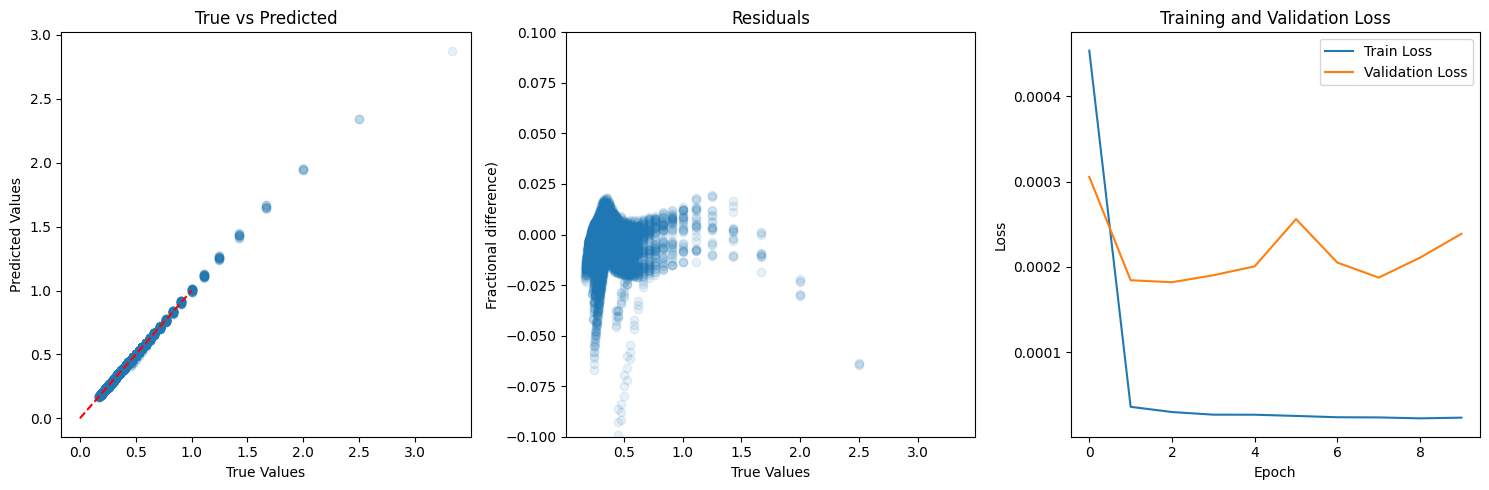

In [45]:
evaluate_model(model, test_loader, train_losses, val_losses)